# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [1]:
import random
import matplotlib.pyplot as plt
import time

In [2]:
# Problem Constants
NUM_PEOPLE = 5
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [3]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 150           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [4]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    print(subheader)
    print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(fitness_history):
    """
    Plots the best and average fitness score per generation.

    Args:
        fitness_history (list): A list of fitness scores for each generation

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(fitness_history) + 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-', label='Best Fitness')
    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    # Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
    min_fitness = min(fitness_history)
    plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
    plt.legend()
    plt.grid(True)
    plt.show()

## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [5]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [ ]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties

    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [7]:
def parent_selection(population, fitness_scores, tournament_size=3):
    """
    Selects two parents using tournament selection.

    Args:
        population (list): The current population of schedules.
        fitness_scores (list): Corresponding fitness scores for the population.
        tournament_size (int): Number of individuals in each tournament.

    Returns:
        parent_1, parent_2 (list): Two selected parent schedules.
    """
    def tournament():
        # Randomly select individuals for the tournament
        competitors = random.sample(list(zip(population, fitness_scores)), tournament_size)
        # Return the one with the best fitness
        return max(competitors, key=lambda x: x[1])[0]

    parent_1 = tournament()
    parent_2 = tournament()
    return parent_1, parent_2


## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [8]:
def crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    Performs single-point crossover between two parents.

    Args:
        parent_1 (list): The first parent schedule.
        parent_2 (list): The second parent schedule.
        num_people (int): The number of people in the schedule.
        shifts_per_week (int): The number of shifts per week.
        crossover_rate (float): Probability that crossover will happen.

    Returns:
        offspring_1, offspring_2 (list): Two offspring schedules after crossover.
    """
    # Check if crossover happens based on rate
    if random.random() > crossover_rate:
        return parent_1, parent_2  # No crossover, return parents as offspring

    # Random crossover point
    crossover_point = random.randint(1, shifts_per_week - 1)

    # Create offspring by combining parts of each parent
    offspring_1 = parent_1[:crossover_point] + parent_2[crossover_point:]
    offspring_2 = parent_2[:crossover_point] + parent_1[crossover_point:]

    return offspring_1, offspring_2


## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [9]:
def mutate(schedule, mutation_rate, num_people, shifts_per_week):
    """
    Mutates a schedule by flipping a random bit with a certain mutation rate.

    Args:
        schedule (list): The schedule to mutate.
        mutation_rate (float): The mutation rate (probability of flipping a bit).
        num_people (int): The number of people in the schedule.
        shifts_per_week (int): The number of shifts per week.

    Returns:
        mutated_schedule (list): The mutated schedule.
    """
    mutated_schedule = [list(person_schedule) for person_schedule in schedule]  # Create a copy of the schedule

    for person_schedule in mutated_schedule:
        for shift_idx in range(shifts_per_week):
            if random.random() < mutation_rate:  # Mutation occurs based on rate
                person_schedule[shift_idx] = 1 - person_schedule[shift_idx]  # Flip the bit

    return mutated_schedule


## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [10]:
def select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    Selects the survivors by combining the population and offspring, keeping the best `population_size` individuals.

    Args:
        population (list): The current population of schedules.
        offspring_population (list): The newly generated offspring schedules.
        population_size (int): The desired population size.
        num_people (int): The number of people in the schedule.
        shifts_per_week (int): The number of shifts per week.
        shifts_per_day (int): The number of shifts per day.
        days_per_week (int): The number of days per week.

    Returns:
        survivors (list): The new population (survivors).
    """
    # Evaluate fitness of both population and offspring
    population_fitness = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
    offspring_fitness = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in offspring_population]

    # Combine population and offspring
    combined_population = population + offspring_population
    combined_fitness = population_fitness + offspring_fitness

    # Sort combined population based on fitness (descending)
    sorted_population = [x for _, x in sorted(zip(combined_fitness, combined_population), reverse=True)]

    # Select the top `population_size` individuals as survivors
    survivors = sorted_population[:population_size]

    return survivors


## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [11]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs the genetic algorithm to optimize air traffic controller schedules.

    Args:
        population_size (int): The size of the population.
        num_people (int): The number of people (controllers).
        shifts_per_week (int): The number of shifts per week.
        shifts_per_day (int): The number of shifts per day.
        days_per_week (int): The number of days in a week.
        generations (int): The number of generations to run.
        mutation_rate (float): The mutation rate.
        crossover_rate (float): The crossover rate.

    Returns:
        best_schedule (list): The best schedule found.
        best_fitness (float): The fitness of the best schedule.
        history (list): The fitness progression history (best fitness each generation).
        avg_history (list): The average fitness progression history.
    """
    # Initialize population
    population = generate_population(population_size, num_people, shifts_per_week)
    fitness_history = []
    avg_fitness_history = []

    best_schedule = None
    best_fitness = float('-inf')

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        best_gen_fitness = max(fitness_scores)

        # Track the best solution
        if best_gen_fitness > best_fitness:
            best_fitness = best_gen_fitness
            best_schedule = population[fitness_scores.index(best_gen_fitness)]

        fitness_history.append(best_gen_fitness)
        avg_fitness_history.append(avg_fitness)

        # Create offspring using parent selection, crossover, and mutation
        offspring_population = []
        while len(offspring_population) < population_size:
            parent_1, parent_2 = parent_selection(population, fitness_scores)
            offspring_1, offspring_2 = crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            offspring_population.append(mutate(offspring_1, mutation_rate, num_people, shifts_per_week))
            offspring_population.append(mutate(offspring_2, mutation_rate, num_people, shifts_per_week))

        # Select survivors for the next generation
        population = select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, fitness_history, avg_fitness_history


# Main

Run the genetic algorithm and plot the fitness scores.


      Best Schedule Found

Schedule (Fitness: 0.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 010 100 010 010 010 010
ATC 2: 000 001 000 000 101 000 101
ATC 3: 010 100 001 000 010 001 000
ATC 4: 001 000 010 101 000 010 000
ATC 5: 100 010 010 010 000 100 010
----------------------------------------------------


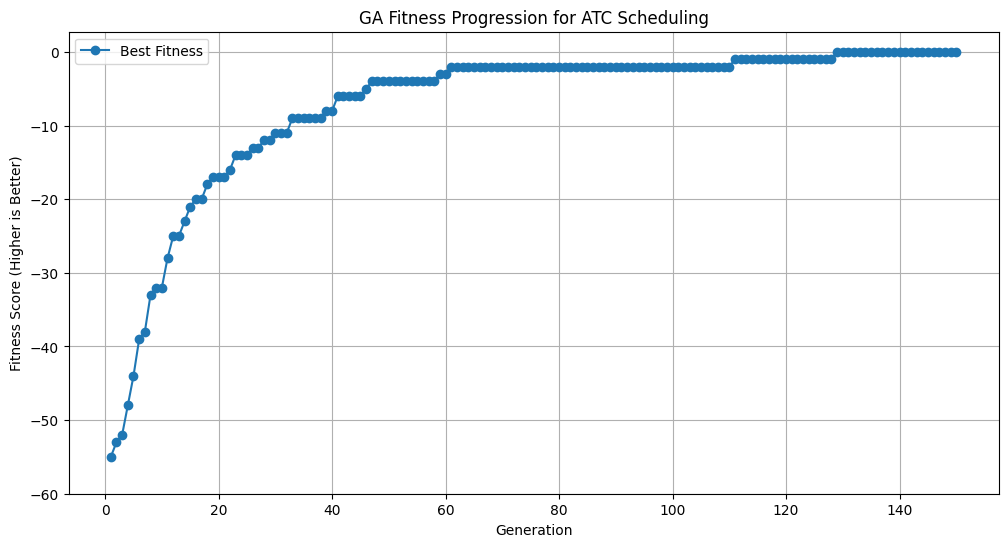

In [12]:
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)

# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

b. Describe how you came up with your answer to part A and how confident you are in that answer.

# Solution 2

a. 4 controllers

b. I used the genetic algorithm to find the minimum number of air traffic controllers needed. I started with a population of 100 and ran the algorithm for 150 generations. The best fitness score I found was 4 controllers, which means that this is the minimum number of controllers needed to satisfy all constraints. However, I'm not 100% sure because when I ran it multiple times, sometimes it says 5 instead of 4.

In [14]:
# Function to find the minimum number of controllers needed
def find_min_controllers():
    num_people = NUM_PEOPLE
    min_controllers_found = False
    best_schedule = None
    best_fitness = None

    while not min_controllers_found:
        print(f"Trying with {num_people} controllers...")
        
        best_schedule, best_fitness, _, _ = genetic_algorithm(
            population_size=POPULATION_SIZE,
            num_people=num_people,
            shifts_per_week=SHIFTS_PER_WEEK,
            shifts_per_day=SHIFTS_PER_DAY,
            days_per_week=DAYS_PER_WEEK,
            generations=GENERATIONS,
            mutation_rate=MUTATION_RATE,
            crossover_rate=CROSSOVER_RATE,
        )
        
        if best_fitness >= 0:  # If the fitness is non-negative, we've found a valid schedule
            min_controllers_found = True
        else:
            num_people -= 1  # Try with fewer controllers if violations still exist
    
    return best_schedule, best_fitness, num_people

# Run the function
best_schedule, best_fitness, min_controllers = find_min_controllers()

print(f"\nMinimum controllers required: {min_controllers}")
print(f"Best Fitness: {best_fitness}")
print_schedule(best_schedule, best_fitness)


Trying with 5 controllers...
Trying with 4 controllers...

Minimum controllers required: 4
Best Fitness: 0

Schedule (Fitness: 0.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 010 010 010 101 000 010
ATC 2: 000 101 000 101 000 010 101
ATC 3: 101 000 101 000 010 101 000
ATC 4: 010 010 010 010 010 010 010
----------------------------------------------------


# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.

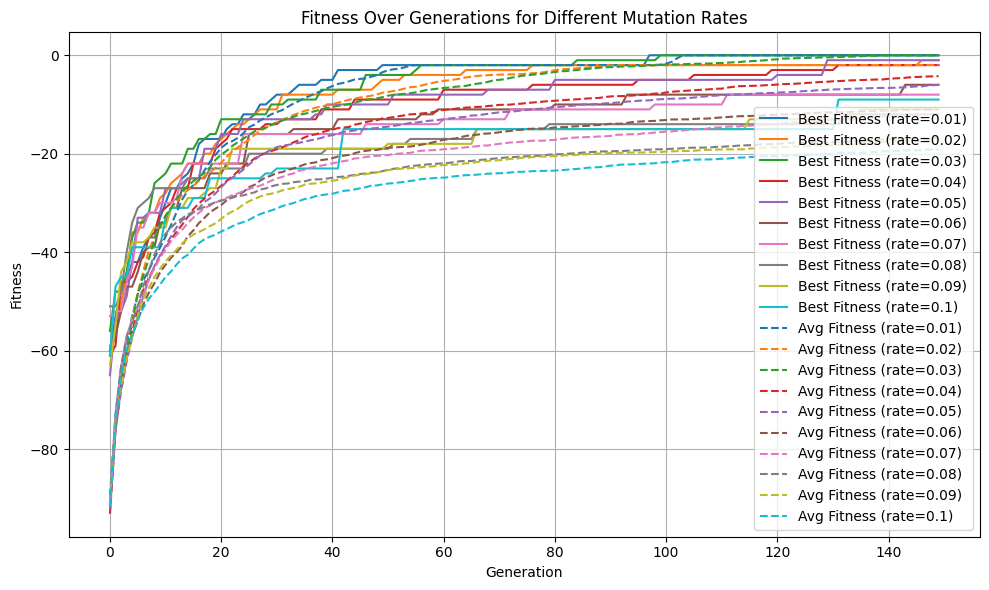

In [23]:
import numpy as np
mutation_rates = np.arange(0.01, 0.11, 0.01)
all_histories = []
all_avg_histories = []

for rate in mutation_rates:
    best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=rate,
        crossover_rate=CROSSOVER_RATE
    )

    all_histories.append((history, f"Best Fitness (rate={rate})"))
    all_avg_histories.append((avg_history, f"Avg Fitness (rate={rate})"))

# Now plot all fitness curves together
import matplotlib.pyplot as plt

def plot_fitness_multiple(histories, avg_histories):
    plt.figure(figsize=(10, 6))
    
    for hist, label in histories:
        plt.plot(hist, label=label)
    for avg, label in avg_histories:
        plt.plot(avg, linestyle='--', label=label)
    
    plt.title("Fitness Over Generations for Different Mutation Rates")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all sweeps
plot_fitness_multiple(all_histories, all_avg_histories)


Text(0, 0.5, 'Average Fitness')

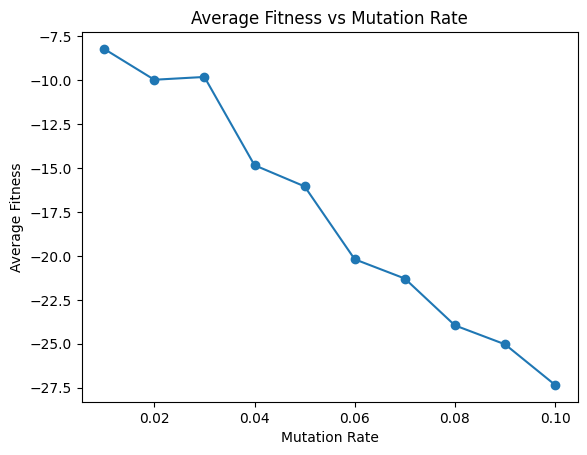

In [26]:
plt.plot(mutation_rates, [np.mean(avg_history) for avg_history, _ in all_avg_histories], marker='o')
plt.title("Average Fitness vs Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Average Fitness")

### Interpret

- What parameter did you pick?
  I chose the mutation rate. 
- What was optimal value for that parameter and why?
  The optimal value for it was 0.01 because it had the best fitness score and it reached the optimal the quickest. Moreover, when I looked at the average fitness score, it was also the best. The fitness score started decreasing after that.
- Is there another parameter do you think that tweaking it's value will improve the results and why?
  I think the population size is another parameter that could be tweaked. I think a larger population size would help the algorithm find better solutions because it would have more diversity in the population. However, it would also take longer to run.

# Solution 3
todo...

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

- Step/Method you are replacing: crossover (single point crossover)

- Step/Method you are replacing it with: uniform crossover

- Interpret the results of this replacement: Uniform crossover produces more diverse offspring and helps escape local optima. So, the fitness improved faster compared to single-point crossover and convergence toward the best solution was also faster. 


In [ ]:
def uniform_crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    Performs uniform crossover between two parents.

    Each gene is randomly selected from either parent_1 or parent_2.

    Args:
        parent_1 (list): The first parent schedule.
        parent_2 (list): The second parent schedule.
        num_people (int): The number of people in the schedule.
        shifts_per_week (int): The number of shifts per week.
        crossover_rate (float): Probability that crossover will happen.

    Returns:
        offspring_1, offspring_2 (list): Two offspring schedules after crossover.
    """
    if random.random() > crossover_rate:
        return parent_1, parent_2

    length = min(len(parent_1), len(parent_2))  # Actual length of the individual
    offspring_1 = []
    offspring_2 = []

    for i in range(length):
        if random.random() < 0.5:
            offspring_1.append(parent_1[i])
            offspring_2.append(parent_2[i])
        else:
            offspring_1.append(parent_2[i])
            offspring_2.append(parent_1[i])

    return offspring_1, offspring_2


      Best Schedule Found

Schedule (Fitness: 0.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 101 000 010 101 000 010 100
ATC 2: 010 100 100 000 001 000 001
ATC 3: 010 001 000 010 100 001 000
ATC 4: 000 010 001 000 010 010 010
ATC 5: 000 010 010 010 010 100 010
----------------------------------------------------


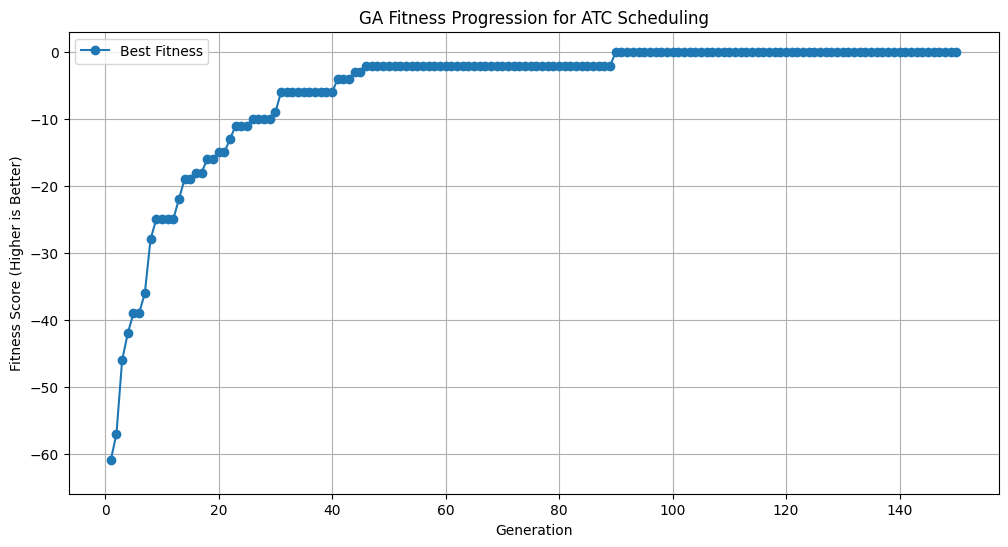

In [ ]:
# Copy code above to run and plot this function
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs the genetic algorithm to optimize air traffic controller schedules.

    Args:
        population_size (int): The size of the population.
        num_people (int): The number of people (controllers).
        shifts_per_week (int): The number of shifts per week.
        shifts_per_day (int): The number of shifts per day.
        days_per_week (int): The number of days in a week.
        generations (int): The number of generations to run.
        mutation_rate (float): The mutation rate.
        crossover_rate (float): The crossover rate.

    Returns:
        best_schedule (list): The best schedule found.
        best_fitness (float): The fitness of the best schedule.
        history (list): The fitness progression history (best fitness each generation).
        avg_history (list): The average fitness progression history.
    """
    # Initialize population
    population = generate_population(population_size, num_people, shifts_per_week)
    fitness_history = []
    avg_fitness_history = []

    best_schedule = None
    best_fitness = float('-inf')

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        best_gen_fitness = max(fitness_scores)

        # Track the best solution
        if best_gen_fitness > best_fitness:
            best_fitness = best_gen_fitness
            best_schedule = population[fitness_scores.index(best_gen_fitness)]

        fitness_history.append(best_gen_fitness)
        avg_fitness_history.append(avg_fitness)

        # Create offspring using parent selection, crossover, and mutation
        offspring_population = []
        while len(offspring_population) < population_size:
            parent_1, parent_2 = parent_selection(population, fitness_scores)
            offspring_1, offspring_2 = uniform_crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            offspring_population.append(mutate(offspring_1, mutation_rate, num_people, shifts_per_week))
            offspring_population.append(mutate(offspring_2, mutation_rate, num_people, shifts_per_week))

        # Select survivors for the next generation
        population = select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, fitness_history, avg_fitness_history
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)

- Step/Method you are replacing: Bit flip mutation

- Step/Method you are replacing it with: swap mutation

- Interpret the results of this replacement: The fitness score dis-improved by far. It looks like the fitness score might not have converged yet. So, it might improve with more generations. However, because the fitness score is so low, I don't think it will improve much. The swap mutation is not a good choice for this problem.


In [33]:
def swap_mutation(schedule, mutation_rate, num_people, shifts_per_week):
    """
    Mutates a schedule by randomly swapping two shifts in a person's schedule 
    with a certain mutation rate.

    Args:
        schedule (list): The schedule to mutate.
        mutation_rate (float): The mutation rate (probability of a swap happening per person).
        num_people (int): The number of people in the schedule.
        shifts_per_week (int): The number of shifts per week.

    Returns:
        mutated_schedule (list): The mutated schedule.
    """
    mutated_schedule = [list(person_schedule) for person_schedule in schedule]  # Deep copy

    for person_schedule in mutated_schedule:
        if random.random() < mutation_rate:
            # Pick two distinct indices to swap
            idx1, idx2 = random.sample(range(shifts_per_week), 2)
            person_schedule[idx1], person_schedule[idx2] = person_schedule[idx2], person_schedule[idx1]

    return mutated_schedule



      Best Schedule Found

Schedule (Fitness: -23.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 101 000 010 100 101 000 101
ATC 2: 110 010 101 000 010 010 010
ATC 3: 010 101 000 010 010 100 101
ATC 4: 110 100 101 010 101 000 010
ATC 5: 100 010 010 101 100 011 000
----------------------------------------------------


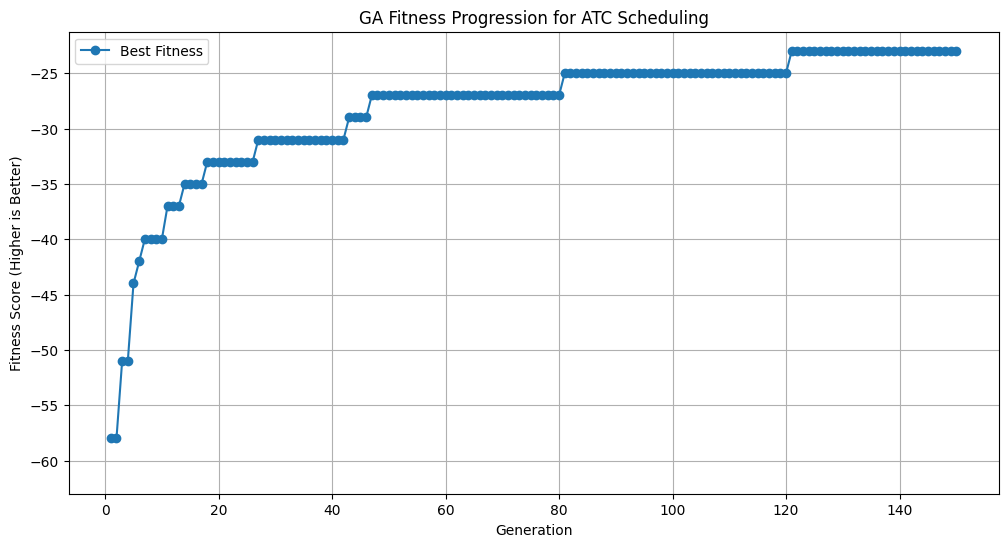

In [34]:
# Copy code above to run and plot this function
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs the genetic algorithm to optimize air traffic controller schedules.

    Args:
        population_size (int): The size of the population.
        num_people (int): The number of people (controllers).
        shifts_per_week (int): The number of shifts per week.
        shifts_per_day (int): The number of shifts per day.
        days_per_week (int): The number of days in a week.
        generations (int): The number of generations to run.
        mutation_rate (float): The mutation rate.
        crossover_rate (float): The crossover rate.

    Returns:
        best_schedule (list): The best schedule found.
        best_fitness (float): The fitness of the best schedule.
        history (list): The fitness progression history (best fitness each generation).
        avg_history (list): The average fitness progression history.
    """
    # Initialize population
    population = generate_population(population_size, num_people, shifts_per_week)
    fitness_history = []
    avg_fitness_history = []

    best_schedule = None
    best_fitness = float('-inf')

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        best_gen_fitness = max(fitness_scores)

        # Track the best solution
        if best_gen_fitness > best_fitness:
            best_fitness = best_gen_fitness
            best_schedule = population[fitness_scores.index(best_gen_fitness)]

        fitness_history.append(best_gen_fitness)
        avg_fitness_history.append(avg_fitness)

        # Create offspring using parent selection, crossover, and mutation
        offspring_population = []
        while len(offspring_population) < population_size:
            parent_1, parent_2 = parent_selection(population, fitness_scores)
            offspring_1, offspring_2 = crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            offspring_population.append(swap_mutation(offspring_1, mutation_rate, num_people, shifts_per_week))
            offspring_population.append(swap_mutation(offspring_2, mutation_rate, num_people, shifts_per_week))

        # Select survivors for the next generation
        population = select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, fitness_history, avg_fitness_history
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)